In [4]:
import numpy as np 
from scipy import stats 
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from scipy.optimize import minimize 
import matplotlib.colors as colors
import sys
from iminuit import Minuit
import pandas as pd

In [5]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [6]:
COLOUR = ['#1E90FF', # 0 # Dodgerblue
          '#FFBF00', # 1 # Amber
          '#FF6347', # 2 # Tomato
          '#00A86B', # 3 # Jade
          '#8A2BE2', # 4 # Blueviolet
          '#FF6FFF', # 5 # Ultra Pink
          '#00CCFF', # 6 # Vivid Sky Blue
          '#FFD800', # 7 # School Bus Yellow
          '#FF004F', # 8 # Folly
          '#0063A6', # 9 # Lapis Lazuli
        ]
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
   
    LINE = ['-', '-.', '--', '-.', ':','--','-.','-', ':', '--']
    MARKER = ['.','*', '^', 's', '.', 'p', 'o', 's', '.', 'd']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF)+
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(10)


* fitting function

In [7]:
def compute_f(f, x, *par):
    try:
        return f(x, *par)
    except ValueError:
        return np.array([f(xi, *par) for xi in x])

In [8]:
def llh(f, data, *par):
    fx = compute_f(f, data, *par)
    likelihood = np.prod(fx)
    return likelihood

In [9]:
def ln_llh(f, data, *par):
    # Evaluate the pdf for the data with the given parameters
    fx = compute_f(f, data, *par)

    values = np.where(fx > 0, fx, np.finfo(float).tiny)
    
    # Take the log of the safe pdf values
    ln_values = np.log(values)
    
    # Sum the log values to get the log-likelihood
    return np.sum(ln_values)
    

In [10]:
def showMaker(llh, sigs, mus, xlabel, ylabel, title = 'Raster Scan'):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Set the extent of the image so that it matches the ranges of sigma and mu
    extent = [sigs[0], sigs[-1], mus[0], mus[-1]]

    # Use extent in imshow
    im = ax.imshow(llh, origin='lower', aspect='auto', cmap='GnBu', extent=extent)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.colorbar(im, ax=ax)
    plt.show()

In [11]:
np.random.seed(75)

In [12]:
def quadratic(x, a0, alpha, beta):
    return a0 + alpha*x + beta*x**2

In [13]:
def integrateMC(f, bound, *par):
    N = 2000
    x = np.random.uniform(bound[0], bound[1], N)
    fx = f(x, *par)  # Evaluate f(x, *par) first
    y = np.random.uniform(0, np.max(fx), N)  # Use np.max() instead of max()
    ratio = np.sum(y < fx) / N
    norm = ratio * (bound[1] - bound[0]) * np.max(fx)  # Use np.max() instead of max()
    return norm

In [14]:
def quadratic_pdf(x, a0, alpha, beta):
    integral = integrateMC(quadratic, [-1, 1], a0, alpha, beta)
    return quadratic(x, a0, alpha, beta)/integral

* likelihood is how much a given data is likely to be generated from a given model.
* `x` is the given data
* `f` is the given model

In [15]:
def generateQuadraticData(y, xmin, xmax, N):
    x_samples = np.random.uniform(xmin, xmax, N)
    ymax = np.max(y)
    ymin = 0
    y_samples = np.random.uniform(ymin, ymax, N)
    return x_samples, y_samples

In [16]:
def accept(x, y, x_sample, y_sample, pdf_x_sample):
    accept_ind = np.where(pdf_x_sample > y_sample)[0]
    reject_ind = np.where(pdf_x_sample < y_sample)[0]
    
    x_acceped = x_sample[accept_ind]
    y_acceped = y_sample[accept_ind]
    x_rejected = x_sample[reject_ind]
    y_rejected = y_sample[reject_ind]

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(x_acceped,y_acceped,label = 'accepted MC samples')
    ax.plot(x, y, label = 'PDF', color = 'tomato', marker = '', linestyle = '-')
    ax.scatter(x_rejected,y_rejected, label = 'rejected MC samples', marker = '*')
    ax.set_title('Accept-Reject')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.legend()
    return x_acceped


In [17]:
def ln_llh_quadratic(x, alpha, beta):
    return -ln_llh(quadratic_pdf, x, 1, alpha, beta)

In [18]:
def minimise(x, alpha_test, beta_test):
    lambda_neg_LLH = lambda params: ln_llh_quadratic(x, params[0], params[1])
    res = minimize(lambda_neg_LLH,x0=[alpha_test,beta_test],bounds=((-0.2,1),(0,1)),method='L-BFGS-B')
    errors = np.sqrt(np.diag(res.hess_inv.todense()))
    # print(res)
    # print(errors)
    return res, errors

UnboundLocalError: local variable 'llh_scan' referenced before assignment

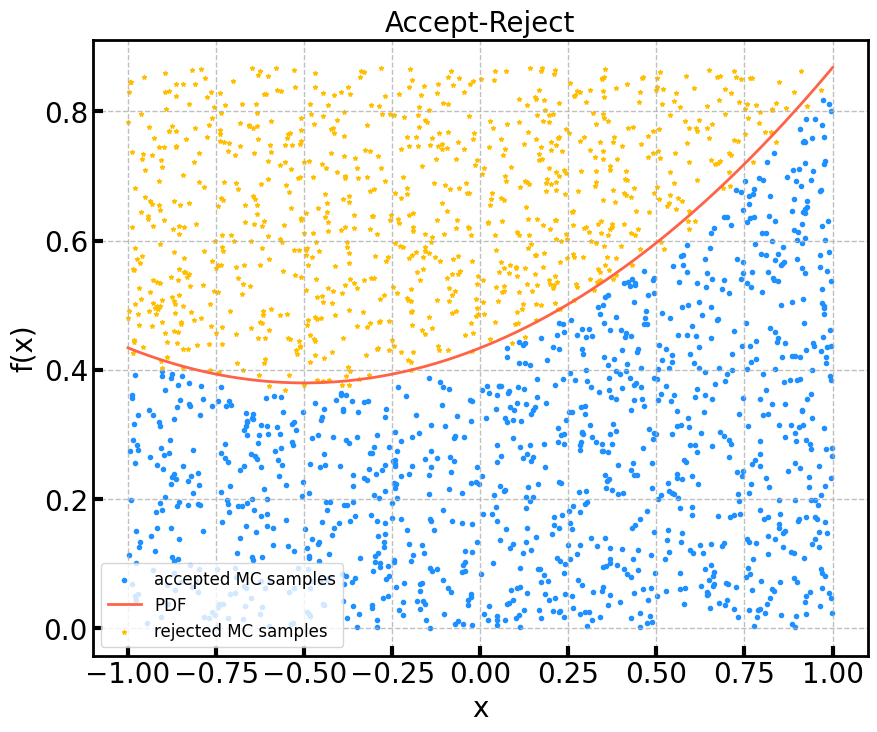

In [19]:
def RasterScan():
    a0 = 1
    ALPHA = 0.5
    BETA = 0.5
    N_sample = 2000
    XMIN = -1
    XMAX = 1

    ## PDF itself with true values
    x_range = np.linspace(XMIN, XMAX, 1000)
    pdf_x_range = quadratic_pdf(x_range, a0, ALPHA, BETA)

    ## Generate tests
    x_sample, y_sample = generateQuadraticData(pdf_x_range, XMIN, XMAX, N_sample)
    pdf_x_sample = quadratic_pdf(x_sample, a0, ALPHA, BETA)
    x_accepted = accept(x_range, pdf_x_range, x_sample, y_sample, pdf_x_sample)

    alpha_test = 0.6
    beta_test = 0.5
    ## Minimise
    res, error = minimise(x_accepted, alpha_test, beta_test)

    ## Raster Scan
    alphas = np.linspace(-0.3, 1, 100)
    betas = np.linspace(0, 1, 100)

    # alpha_grid, beta_grid = np.meshgrid(alphas, betas)
    # alpha_grid = alpha_grid.flatten()
    # beta_grid = beta_grid.flatten()
    # llh_scan = np.zeros(len(alpha_grid))

    ab = np.array(list(itertools.product(alphas, betas)))
    alpha_grid = np.expand_dims(ab[:,0],axis=1)
    beta_grid = np.expand_dims(ab[:,1],axis=1)


    # Compute log-likelihood for each combination of alpha and beta
    for i, (alpha, beta) in enumerate(zip(alpha_grid, beta_grid)):
        llh_scan[i] = ln_llh_quadratic(x_accepted, alpha, beta)

    # Reshape llh_scan to match the grid shape
    llh_scan = llh_scan.reshape(len(alphas), len(betas))

    fig, ax = plt.subplots(figsize=(10, 8))
    sc = ax.scatter(alpha_grid, beta_grid, c=llh_scan.flatten(), cmap='GnBu')  # Use the flattened array


    ax.plot(alpha_test, beta_test, label='True Value')
    ax.plot(res.x[0], res.x[1], label='Minimised Value')
    ax.contour(alpha_grid.reshape(len(alphas), len(betas)), 
               beta_grid.reshape(len(alphas), len(betas)),  
               -2*(llh_scan+res.fun).reshape(len(alphas),len(betas)), 
               [2.3,4.6,6])

    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    ax.legend()

RasterScan()
